# Detecção de fraude em seguro de veículo



## Sobre

**Autor:** Pedro Vitor Soares Gomes de Lima

### Objetivo

Detectar e evitar processos fraudulentos é um enorme desafio. Para tal, o uso de técnicas de machine learning tem se mostrado bastante promissor. Porém, um bom desempenho de um modelo de machine learning depende de uma etapa que não é simples: entender e tratar os diversos dados de diferentes naturezas que estão em posse das seguradoras.

E este é o foco principal do projeto: entender cada variável disponibilizada na base de dados e tratá-las adequadamente. Dessa forma, é possível utilizá-las no desenvolvimento de algoritmos de classificação. O que também será realizado, escolhendo alguns métodos existentes e avaliando diferentes configurações destes.

### Base de dados

A base de dados escolhida contém diversas informações sobre pedidos de indenização de uma seguradora de veículos. As informações se referem à pessoa envolvida em um acidente, à apólice contratada, ao titular da apólice, ao veículo envolvido, etc. Originalmente são 15420 registros, onde o atributo 'FraudFound_P' indica se uma determinada solicitação foi ou não identificada como fraudulenta.

Disponível em: https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection

### Sumário

PARTE 1: Importar bibliotecas

PARTE 2: Importar base de dados

PARTE 3: Entendimento da base de dados

PARTE 4: Tratamento dos dados

PARTE 5: Investigar relações com a variável alvo

PARTE 6: Transformar dados

PARTE 7: Investigar relações com a variável alvo (novamente)

PARTE 8: Dividir variáveis dependentes e independentes

PARTE 9: Dividir dados de treino e de teste

PARTE 10: Balancear dados de treino

PARTE 11: Rodar experimentos

PARTE 12: Analisar os resultados

PARTE 13: Investigar o melhor modelo

PARTE 14: Conclusão e discussão

## PARTE 1: Importar bibliotecas

In [1]:
import numpy as np                                                   # realizar cálculos em arrays multidimensionais
import pandas as pd                                                  # manipulação e análise de dados
import seaborn as sns                                                # visualização de gráficos estatísticos
import scipy.stats as stats                                          #
import matplotlib.pyplot as plt                                      # criação de gráficos e visualizações de dados em geral

from imblearn.over_sampling import ADASYN                            # método de balanceamento ADASYN
from sklearn.model_selection import train_test_split                 # dividir a base de dados em treino e teste

from sklearn.ensemble import RandomForestClassifier                  # método de classificação Random Forest
from sklearn.model_selection import RepeatedStratifiedKFold          # método de validação cruzada
from sklearn.model_selection import GridSearchCV                     # testar diferentes valores de parâmetros para um método
from sklearn.inspection import permutation_importance                # visualizar relavância dos atributos em um método
from sklearn import metrics                                          # importar métricas de avaliação

# a saída dos comandos de plotagem é exibida diretamente abaixo da célula
%matplotlib inline

## PARTE 2: Importar base de dados

In [2]:
url_dataset = "https://github.com/peuvitor/insurance-fraud-detection/blob/main/dataset/fraud_oracle.csv?raw=true"

df_dataset = pd.read_csv(url_dataset)

## PARTE 3: Entendimento da base de dados

### 3.1. Investigar as colunas existentes

Quantas e quais são as colunas? Quais são os seus respectivos tipos?

In [3]:
df_dataset.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [4]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

### 3.2. Valores únicos de cada coluna

Verificar quais os possíveis valores encontrados na base de dados para cada atributo. Além disso, essa parte será útil para identificar possíveis valores faltantes ou incomuns.

In [5]:
for coluna in df_dataset.columns:
    valores_unicos = df_dataset[coluna].unique()
    print(f"--> '{coluna}' possui {len(valores_unicos)} valores únicos, são eles:\n {valores_unicos}")

--> 'Month' possui 12 valores únicos, são eles:
 ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']
--> 'WeekOfMonth' possui 5 valores únicos, são eles:
 [5 3 2 4 1]
--> 'DayOfWeek' possui 7 valores únicos, são eles:
 ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']
--> 'Make' possui 19 valores únicos, são eles:
 ['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']
--> 'AccidentArea' possui 2 valores únicos, são eles:
 ['Urban' 'Rural']
--> 'DayOfWeekClaimed' possui 8 valores únicos, são eles:
 ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']
--> 'MonthClaimed' possui 13 valores únicos, são eles:
 ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']
--> 'WeekOfMonthClaimed' possui 5 valores únicos, são eles:
 [1 4 2 3 5]
--> 'Sex' possui 2 valores únicos, são eles:
 ['Femal

### 3.3. Resumo sobre as colunas

Breve entendimento de cada atributo. Levando em conta o contexto do problema, em geral o nome da coluna é autoexplicativo, porém, em alguns momentos pode dar margem à mais de uma interpretação. Aqui explicarei o que é cada atributo, como trabalharei com ele e problemas que precisam ser investigados.

1. **Month** (object):  
    - considerarei como o mês em que o acidente ocorreu
    - mês abreviado (3 primeiras letras, em inglês)
    - contém os 12 possíveis meses, não há valores faltantes nem incompatíveis

2. **WeekOfMonth** (int64):
    - considerarei como a semana do mês em que o acidente ocorreu
    - contém valores inteiros de 1 a 5

3. **DayOfWeek** (object):
    - considerarei como o dia da semana em que o acidente ocorreu
    - nome do dia da semana completo, em inglês
    - contém os 7 possíveis dias da semana, não há valores faltantes nem incompatíveis

4. **Make** (object):
    - considerarei como a marca do veículo envolvido no acidente
    - contém uma lista com 19 fabricantes

5. **AccidentArea** (object):
    - informa se o acidente ocorreu em uma área rural ou urbana

6. **DayOfWeekClaimed** (object):
    - dia da semana referente ao pedido de seguro
    - nome do dia da semana completo, em inglês
    - contém 8 valores únicos (7 possíveis dias da semana + '0'), a seguir serão investigados mais a fundo

7. **MonthClaimed** (object):
    - mês referente ao pedido de seguro
    - mês abreviado (3 primeiras letras, em inglês)
    - contém 13 valores únicos (12 possíves meses + '0'), a seguir serão investigados mais a fundo

8. **WeekOfMonthClaimed** (int64):
    - semana do mês referente ao pedido de seguro
    - contém valores inteiros de 1 a 5

9. **Sex** (object):
    - é o sexo biológico da pessoa envolvida no acidente ou da pessoa solicitando o seguro? (considerarei a primeira opção)
    - pode ser: sexo masculino ou feminino

10. **MaritalStatus** (object):
    - é o estado civil da pessoa envolvida no acidente ou da pessoa solicitando o seguro? (considerarei a primeira opção)
    - pode ser: solteiro, casado, divorciado ou viúvo

11. **Age** (int64):
    - é a idade da pessoa envolvida no acidente ou da pessoa solicitando o seguro? (considerarei a primeira opção)
    - valores inteiros de 16 a 80 (a seguir, o valor '0' será investigado mais a fundo)

12. **Fault** (object):
    - indica quem foi considerado como o responsável pelo acidente
    - pode ser: titular do seguro ou terceiro

13. **PolicyType** (object):
    - indica o tipo da apólice contratada
    - contém uma lista com 9 tipos, onde cada um é composto por 'categoria do veículo' + 'tipo do seguro'
        - categoria do veículo: sport, sedan, utility
        - tipo de seguro: liability, all perils, collision
    - já existe um atributo para indicar a categoria do veículo (VehicleCategory) e outra para indicar o tipo de seguro (BasePolicy), a seguir verificarei como tratar essas informações duplicadas

14. **VehicleCategory** (object):
    - indica a categoria do veículo registrado na apólice/envolvido no acidente
    - pode ser: sport, sedan, utility

15. **VehiclePrice** (object):
    - indica o preço do veículo envolvido no acidente
    - contém 6 faixas de valores (provavelmente em dólares) 
    - duas abordagens serão avaliadas: considerar como um dado categórico ou substituir os intervalos pelo valor médio

16. **FraudFound_P** (int64):
    - indica se aquela solicitação foi ou não uma fraude
    - é o atributo alvo

17. **PolicyNumber** (int64):
    - identifica cada pedido de seguro
    - contém 15420 valores inteiros únicos, de 1 a 15420
    - a seguir será verificada a relação entre o número da linha e o PolicyNumber, possivelmente são a mesma coisa

18. **RepNumber** (int64):
    - indica o número do representante
    - contém valores inteiros de 1 a 16
    - não fica claro a relevância do parâmetro para o problema, a seguir isso será investigado

19. **Deductible** (int64):
    - indica o valor da franquia do seguro
    - 4 opções de valores inteiros: 300, 400, 500 e 700

20. **DriverRating** (int64):
    - alguma métrica de avaliação do motorista
    - contém valores inteiros de 1 a 4
    - não fica claro se esses dados se traduzem em categorias ou se estão dentro de um certo intervalo de avaliação

21. **Days_Policy_Accident** (object):
    - será considerado como o número de dias que se passaram entre a compra da apólice e o acidente
    - contém 5 faixas de valores 
    - duas abordagens serão avaliadas: considerar como um dado categórico ou substituir os intervalos pelo valor médio

22. **Days_Policy_Claim** (object):
    - será considerado como o número de dias que se passaram entre a compra da apólice e o pedido de indenização
    - contém 4 faixas de valores 
    - duas abordagens serão avaliadas: considerar como um dado categórico ou substituir os intervalos pelo valor médio

23. **PastNumberOfClaims** (object):
    - indica quantas vezes a mesma pessoa realizou pedidos de indenização
    - contém 4 faixas de valores

24. **AgeOfVehicle** (object):
    - indica a idade do veículo (considerarei referenre ao momento do acidente)
    - contém 8 faixas de valores 
    - duas abordagens serão avaliadas: considerar como um dado categórico ou substituir os intervalos pelo valor médio

25. **AgeOfPolicyHolder** (object):
    - indica a idade do titular da apólice
    - contém 9 faixas de valores
    - duas abordagens serão avaliadas: considerar como um dado categórico ou substituir os intervalos pelo valor médio

26. **PoliceReportFiled** (object):
    - indica se foi feito um boletim de ocorrência para o acidente
    - pode ser: sim ou não

27. **WitnessPresent** (object):
    - indica se uma testemunha estava presente no momento do acidente
    - pode ser: sim ou não

28. **AgentType** (object):
    - classifica um agente (relacionado ao acidente ou ao pedido) como externo ou interno
    - não fica claro a relevância do parâmetro para o problema, a seguir isso será investigado

29. **NumberOfSuppliments** (object):
    - indica algum tipo de suplemento no seguro
    - contém 4 faixas de valores
    - duas abordagens serão avaliadas: considerar como um dado categórico ou substituir os intervalos pelo valor médio
    - não fica claro a relevância do parâmetro para o problema, a seguir isso será investigado

30. **AddressChange_Claim** (object):
    - indica quantos anos se passaram entre a última vez que foi registrado uma mudança de endereço e o pedido de indenização
    - contém 5 faixas de valores
    - duas abordagens serão avaliadas: considerar como um dado categórico ou substituir os intervalos pelo valor médio

31. **NumberOfCars** (object):
    - considerarei como o número de carros cobertos pela apólice (outra possibilidade seria o número de carros envolvidos no acidente)
    - contém 5 faixas de valores
    - duas abordagens serão avaliadas: considerar como um dado categórico ou substituir os intervalos pelo valor médio

32. **Year** (int64):
    - considerarei como o ano em que o acidente ocorreu
    - pode ser: 1994, 1995 e 1996

33. **BasePolicy** (object):
    - indica o tipo de seguro contratado
    - pode ser: liability, all perils, collision

## PARTE 4: Tratamento dos dados

In [6]:
df_dataset_1 = df_dataset.copy()

### 4.1. Verificar relação entre os índices das linhas do dataset e 'PolicyNumber'

PolicyNumber é igual ao índice da linha+1?

In [7]:
df_dataset_1['PolicyNumber'].describe

<bound method NDFrame.describe of 0            1
1            2
2            3
3            4
4            5
         ...  
15415    15416
15416    15417
15417    15418
15418    15419
15419    15420
Name: PolicyNumber, Length: 15420, dtype: int64>

In [8]:
df_dataset_total_linhas = len(df_dataset_1)

PolicyNumber_e_indice = sum(1 if df_dataset_1['PolicyNumber'].iloc[indice] == indice+1 else 0 \
                                    for indice in range(df_dataset_total_linhas))

print(f"Número de linhas do dataset: {df_dataset_total_linhas}")
print(f"Quantidade de linhas onde PolicyNumber = indice+1: {PolicyNumber_e_indice}")

Número de linhas do dataset: 15420
Quantidade de linhas onde PolicyNumber = indice+1: 15420


Como a suposição foi provada verdadeira, esta coluna será ignorada, pois não apresenta utilidade para o problema em questão.

In [9]:
df_dataset_1.drop(columns='PolicyNumber', inplace=True)

### 4.2. Tratar o valor 0 encontrado em 'DayOfWeekClaimed', 'MonthClaimed' e 'Age'

In [10]:
##### 'DayOfWeekClaimed' e 'MonthClaimed'

DayOfWeekClaimed_zeros = df_dataset_1.index[df_dataset_1['DayOfWeekClaimed'] == '0'].tolist()
MonthClaimed_zeros = df_dataset_1.index[df_dataset_1['MonthClaimed'] == '0'].tolist()

print("DayOfWeekClaimed e MonthClaimed possuem o valor '0' na(s) mesma(s) linha(s):", DayOfWeekClaimed_zeros == MonthClaimed_zeros)
print("Índice(s):", DayOfWeekClaimed_zeros)

# como trata-se apenas de uma única ocorrência, a linha correspondente será eliminada
df_dataset_1 = df_dataset_1.drop(DayOfWeekClaimed_zeros)
df_dataset_1.reset_index(drop=True, inplace=True)


DayOfWeekClaimed e MonthClaimed possuem o valor '0' na(s) mesma(s) linha(s): True
Índice(s): [1516]


In [11]:
##### 'Age'

Age_zeros = df_dataset_1.index[df_dataset_1['Age'] == 0].tolist()
print(f"Age possui o valor '0' em {len(Age_zeros)} linhas. \n")

# partirei do seguinte questionamento: nessas ocasiões, existe alguma relação com outra coluna que pode ser útil?

for coluna in df_dataset_1.columns:
    linhas_age0 = df_dataset_1.loc[df_dataset_1['Age']==0, coluna].unique()
    if len(linhas_age0) < 2 and coluna != 'Age':
        print(f"--> Correspondência para '{coluna}': {linhas_age0}")


Age possui o valor '0' em 319 linhas. 

--> Correspondência para 'Sex': ['Male']
--> Correspondência para 'MaritalStatus': ['Single']
--> Correspondência para 'Days_Policy_Accident': ['more than 30']
--> Correspondência para 'Days_Policy_Claim': ['more than 30']
--> Correspondência para 'AgeOfPolicyHolder': ['16 to 17']


In [12]:
df_dataset_1['AgeOfPolicyHolder'].value_counts().sort_index()

16 to 17     319
18 to 20      15
21 to 25     108
26 to 30     613
31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
over 65      508
Name: AgeOfPolicyHolder, dtype: int64

Verificando as colunas que possuem sempre a mesma correspondência, à primeira vista, aquela que pode dar uma solução para Age==0 é 'AgeOfPolicyHolder'.

E, de fato, considerando todo o dataset, temos uma frequência de 319 para '16 to 17' em AgeOfPolicyHolder. Exatamente a mesma quantidade de linhas com Age==0.

Investigarei o seguinte: 'Age' sempre está dentro do intervalo de 'AgeOfPolicyHolder'?

In [13]:
# extrair os limites dos intervalos em 'AgeOfPolicyHolder'
get_intervalo_AgeOfPolicyHolder = lambda linha: [int(linha[:2]), int(linha[-2:])] if 'to' in linha else [int(linha[-2:]), 200]

df_dataset_total_linhas = len(df_dataset_1)
total = 0

for indice in range(df_dataset_total_linhas):
    idade = df_dataset_1['Age'].iloc[indice]
    intervalo_idade = get_intervalo_AgeOfPolicyHolder(df_dataset_1['AgeOfPolicyHolder'].iloc[indice])
    if ~(idade >= intervalo_idade[0] and idade <= intervalo_idade[1]): total += 1

print(f"Em {total} linhas 'Age' não corresponde a 'AgeOfPolicyHolder'. O que representa {total/df_dataset_total_linhas:.2%} do total de linhas.")

Em 7241 linhas 'Age' não corresponde a 'AgeOfPolicyHolder'. O que representa 46.96% do total de linhas.


A resposta para o questionamento é 'não'. Ou seja, o indivíduo envolvido no acidente não necessariamente é a pessoa titular da apólice do seguro. 

Apesar disso, para não excluir essa quantidade de linhas do dataset, a opção escolhida para dar seguimento ao projeto é a de substituir o valor de 0 de 'Age' pela média do intervalo de 'AgeOfPolicyHolder'.

In [14]:
df_dataset_1.loc[df_dataset_1['Age']==0, 'Age'] = 16.5

Age_zeros = df_dataset_1.index[df_dataset_1['Age'] == 0].tolist()
print(f"Age possui o valor '0' em {len(Age_zeros)} linhas. \n")

Age_mean = df_dataset_1.index[df_dataset_1['Age'] == 16.5].tolist()
print(f"Age possui o valor '16.5' em {len(Age_mean)} linhas. \n")

Age possui o valor '0' em 0 linhas. 

Age possui o valor '16.5' em 319 linhas. 



### 4.3. Verificar relação entre 'PolicyType', 'VehicleCategory' e 'BasePolicy'

PolicyType = "VehicleCategory - BasePolicy"?

In [15]:
df_dataset_1[['PolicyType', 'VehicleCategory', 'BasePolicy']].describe

<bound method NDFrame.describe of                PolicyType VehicleCategory  BasePolicy
0       Sport - Liability           Sport   Liability
1       Sport - Collision           Sport   Collision
2       Sport - Collision           Sport   Collision
3       Sedan - Liability           Sport   Liability
4       Sport - Collision           Sport   Collision
...                   ...             ...         ...
15414   Sedan - Collision           Sedan   Collision
15415   Sedan - Liability           Sport   Liability
15416   Sedan - Collision           Sedan   Collision
15417  Sedan - All Perils           Sedan  All Perils
15418   Sedan - Collision           Sedan   Collision

[15419 rows x 3 columns]>

In [16]:
df_dataset_total_linhas = len(df_dataset_1)
total = 0

for indice in range(df_dataset_total_linhas):
    PolicyType = df_dataset_1['PolicyType'].iloc[indice]
    VehicleCategory_BasePolicy = f"{df_dataset_1['VehicleCategory'].iloc[indice]} - {df_dataset_1['BasePolicy'].iloc[indice]}"
    if PolicyType == VehicleCategory_BasePolicy: total += 1

print(f"'PolicyType' corresponde a 'VehicleCategory - BasePolicy' em {total} linhas. O que representa {total/df_dataset_total_linhas:.2%} do total de linhas.")

'PolicyType' corresponde a 'VehicleCategory - BasePolicy' em 10432 linhas. O que representa 67.66% do total de linhas.


A suposição foi provada falsa, portanto, nada será feito com essas três colunas. Mesmo se a suposição fosse verdadeira, ter as informações tanto separadas quanto combinadas pode ser útil para o modelo a ser construído.

## PARTE 5: Investigar relações com a variável alvo

Usar de testes estatísticos e recursos gráficos para verificar as relações entre os atributos e o target ('FraudFound_P').

### 5.1 Teste de Independência

Considerando os diferentes tipos de atributos (numéricos, binários, categóricos), a abordagem escolhida leva em conta a tabela de contigência para cada par coluna e target. Será realizado o teste de independência chi-quadrado, onde a hipótese nula **$H_0$** é que as colunas **não têm relação** e a hipótese alternativa **$H_1$** é que **existe relação** entre as colunas. O nível de significância (alfa) considerado é de 0,05.

Para os resultados dos testes:

- Se o valor-p encontrado for **maior que alfa**, não rejeitamos a hipótese nula. Podemos dizer que o resultado do teste não detecta uma relação significativa entre as variáveis;

- Se o valor-p encontrado for **menor que alfa**, podemos dizer que há evidências estatísticas suficientes de que existe alguma relação entre as variáveis.

In [17]:
# exemplo de tabela de contigência
pd.crosstab(df_dataset_1['MaritalStatus'], df_dataset_1['FraudFound_P'])

FraudFound_P,0,1
MaritalStatus,,
Divorced,73,3
Married,9986,639
Single,4405,278
Widow,32,3


In [18]:
# teste de independêndia chi-quadrado
nivel_significancia = 0.05
teste_independencia = []

for coluna in df_dataset_1.columns:
    tabela_contigencia = pd.crosstab(df_dataset_1[coluna], df_dataset_1['FraudFound_P'])
    chi2_val, valor_p, _, __ = stats.chi2_contingency(tabela_contigencia)
    if valor_p < nivel_significancia:
        teste_independencia.append([coluna, chi2_val, valor_p])

print("Há evidências estatísticas suficientes de que existe alguma relação entre FraudFound_P e os seguintes atributos:")

df_teste_independencia = pd.DataFrame(teste_independencia, columns=['Atributo', '\u03C7\u00B2', 'Valor-p'])
df_teste_independencia.sort_values(by='Valor-p', inplace=True)
print(df_teste_independencia)

Há evidências estatísticas suficientes de que existe alguma relação entre FraudFound_P e os seguintes atributos:
                Atributo            χ²       Valor-p
10          FraudFound_P  15401.236138  0.000000e+00
7             PolicyType    437.491381  1.768441e-89
20            BasePolicy    402.947238  3.170436e-88
8        VehicleCategory    290.980893  6.520817e-64
6                  Fault    264.984556  1.406180e-59
18   AddressChange_Claim    104.722693  9.704718e-22
11            Deductible     72.406255  1.302831e-15
9           VehiclePrice     67.836116  2.888324e-13
13    PastNumberOfClaims     53.541755  1.405198e-11
1                   Make     59.815292  2.191573e-06
3           MonthClaimed     42.200514  1.495245e-05
2           AccidentArea     16.901858  3.936304e-05
15     AgeOfPolicyHolder     33.104861  5.896560e-05
4                    Sex     13.495678  2.391135e-04
17   NumberOfSuppliments     18.155527  4.085276e-04
5                    Age    109.664968 

### 5.2 Análise Gráfica

Apenas com os atributos que mostram ter uma potencial relação com a variável alvo, utilizarei de recursos gráficos para visualizar mais detalhes dessas relações.

In [19]:
def grafico_barras(tab_cont, titulo, size):
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=size)
    
    tab_cont[0].plot.bar(ax=ax1, color='green', rot=0)
    tab_cont[1].plot.bar(ax=ax2, color='darkred', rot=0)

    ax1.set_title(titulo, size=14, fontweight="bold")
    ax1.set(ylabel='Total - Não Fraude', xlabel='')
    ax2.set(ylabel='Total - Fraude', xlabel='')

    return ax1, ax2

FraudFound_P             0    1
PolicyType                     
Sedan - All Perils    3675  411
Sedan - Collision     5200  384
Sedan - Liability     4951   36
Sport - All Perils      22    0
Sport - Collision      300   48
Sport - Liability        1    0
Utility - All Perils   299   41
Utility - Collision     27    3
Utility - Liability     21    0


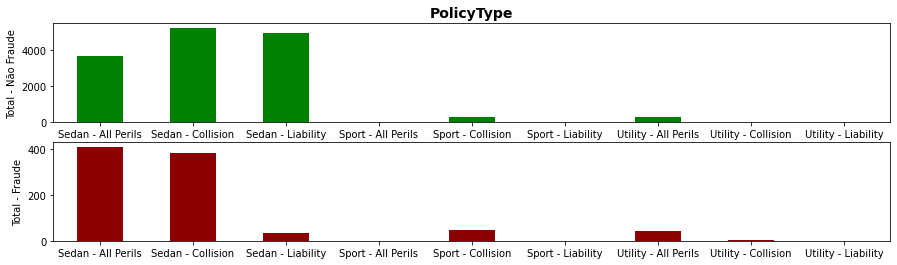

In [20]:
coluna = 'PolicyType'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (15, 4))
plt.show()

FraudFound_P     0    1
BasePolicy             
All Perils    3996  452
Collision     5527  435
Liability     4973   36


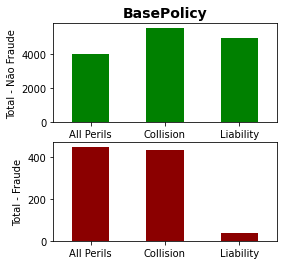

FraudFound_P        0    1
VehicleCategory           
Sedan            8875  795
Sport            5274   84
Utility           347   44


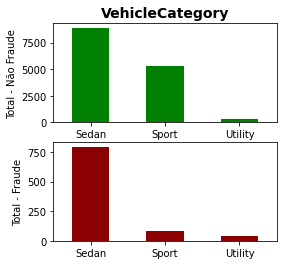

In [21]:
coluna = 'BasePolicy'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (4, 4))
plt.show()

coluna = 'VehicleCategory'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (4, 4))
plt.show()

FraudFound_P       0    1
Fault                    
Policy Holder  10343  886
Third Party     4153   37


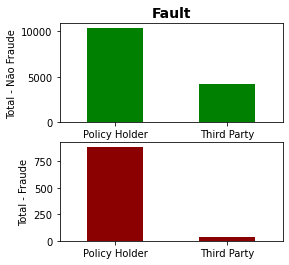

FraudFound_P             0    1
AddressChange_Claim            
1 year                 159   11
2 to 3 years           240   51
4 to 8 years           598   33
no change            13498  825
under 6 months           1    3


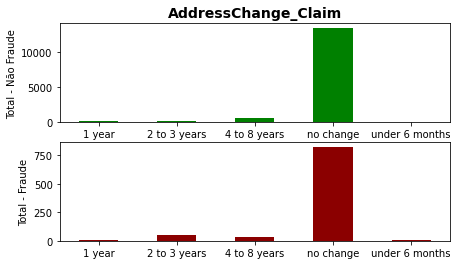

In [22]:
coluna = 'Fault'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (4, 4))
plt.show()

coluna = 'AddressChange_Claim'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (7, 4))
plt.show()

FraudFound_P      0    1
Deductible              
300               6    2
400           13981  856
500             216   47
700             293   18


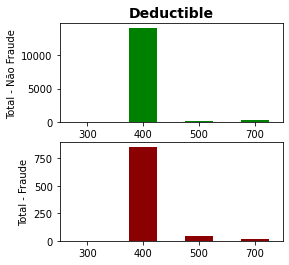

FraudFound_P        0    1
VehiclePrice              
20000 to 29000   7658  421
30000 to 39000   3358  175
40000 to 59000    430   31
60000 to 69000     83    4
less than 20000   993  103
more than 69000  1974  189


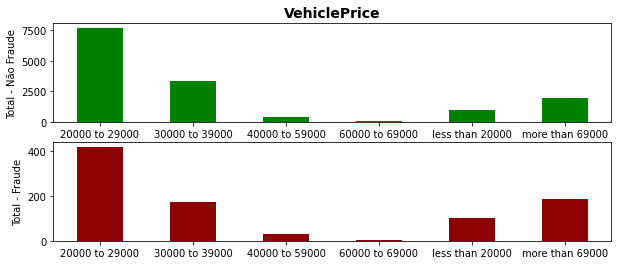

In [23]:
coluna = 'Deductible'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (4, 4))
plt.show()

coluna = 'VehiclePrice'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (10, 4))
plt.show()

FraudFound_P           0    1
PastNumberOfClaims           
1                   3351  222
2 to 4              5191  294
more than 4         1942   68
none                4012  339


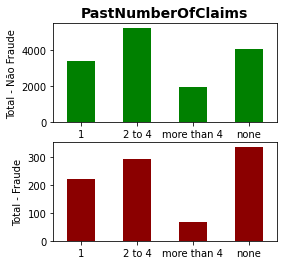

FraudFound_P     0    1
Make                   
Accura         413   59
BMW             14    1
Chevrolet     1587   94
Dodge          107    2
Ferrari          2    0
Ford           417   33
Honda         2621  179
Jaguar           6    0
Lexus            1    0
Mazda         2231  123
Mecedes          3    1
Mercury         77    6
Nisson          29    1
Pontiac       3624  213
Porche           5    0
Saab            97   11
Saturn          52    6
Toyota        2935  186
VW             275    8


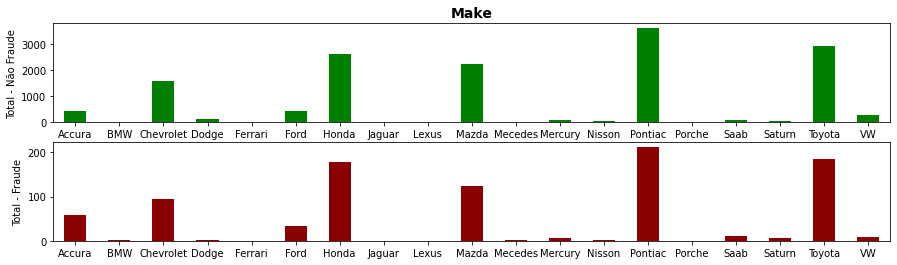

In [24]:
coluna = 'PastNumberOfClaims'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (4, 4))
plt.show()

coluna = 'Make'
tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (15, 4))
plt.show()

FraudFound_P     0    1
MonthClaimed           
Apr           1189   82
Aug           1034   92
Dec           1097   49
Feb           1209   78
Jan           1354   92
Jul           1169   56
Jun           1215   78
Mar           1251   97
May           1309  102
Nov           1239   46
Oct           1266   73
Sep           1164   78


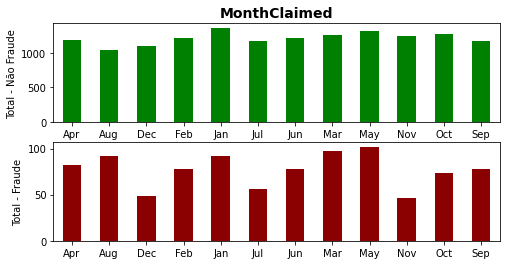

FraudFound_P     0    1
Month                  
Apr           1200   80
Aug           1043   84
Dec           1223   62
Feb           1184   82
Jan           1324   87
Jul           1196   60
Jun           1241   80
Mar           1258  102
May           1273   94
Nov           1155   46
Oct           1235   70
Sep           1164   76


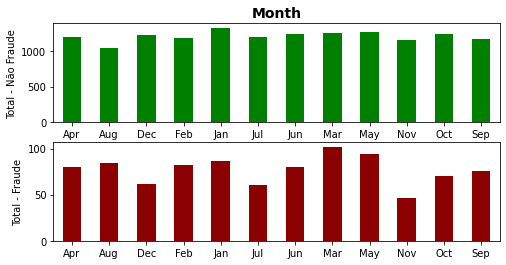

In [25]:
coluna = 'MonthClaimed'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (8, 4))
plt.show()

coluna = 'Month'
tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (8, 4))
plt.show()

FraudFound_P      0    1
AccidentArea            
Rural          1464  133
Urban         13032  790


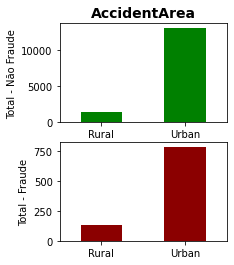

FraudFound_P            0    1
NumberOfSuppliments           
1 to 2               2330  159
3 to 5               1920   97
more than 5          3672  195
none                 6574  472


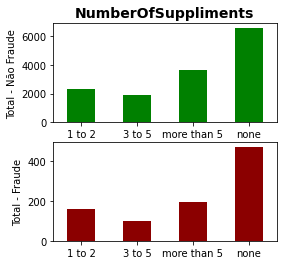

In [26]:
coluna = 'AccidentArea'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (3, 4))
plt.show()

coluna = 'NumberOfSuppliments'
tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (4, 4))
plt.show()

FraudFound_P          0    1
AgeOfPolicyHolder           
16 to 17            288   31
18 to 20             13    2
21 to 25             92   16
26 to 30            580   33
31 to 35           5233  360
36 to 40           3806  237
41 to 50           2684  144
51 to 65           1322   70
over 65             478   30


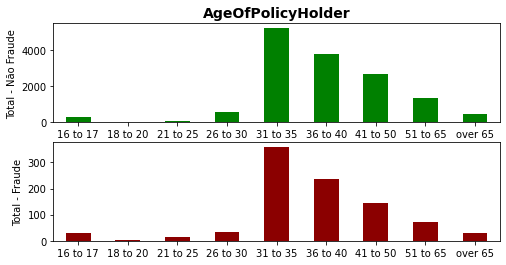

FraudFound_P    0   1
Age                  
16.0            8   1
16.5          288  31
17.0            5   1
18.0           40   8
19.0           27   5
...           ...  ..
76.0           39   3
77.0           28   1
78.0           33   2
79.0           19   1
80.0           31   1

[66 rows x 2 columns]


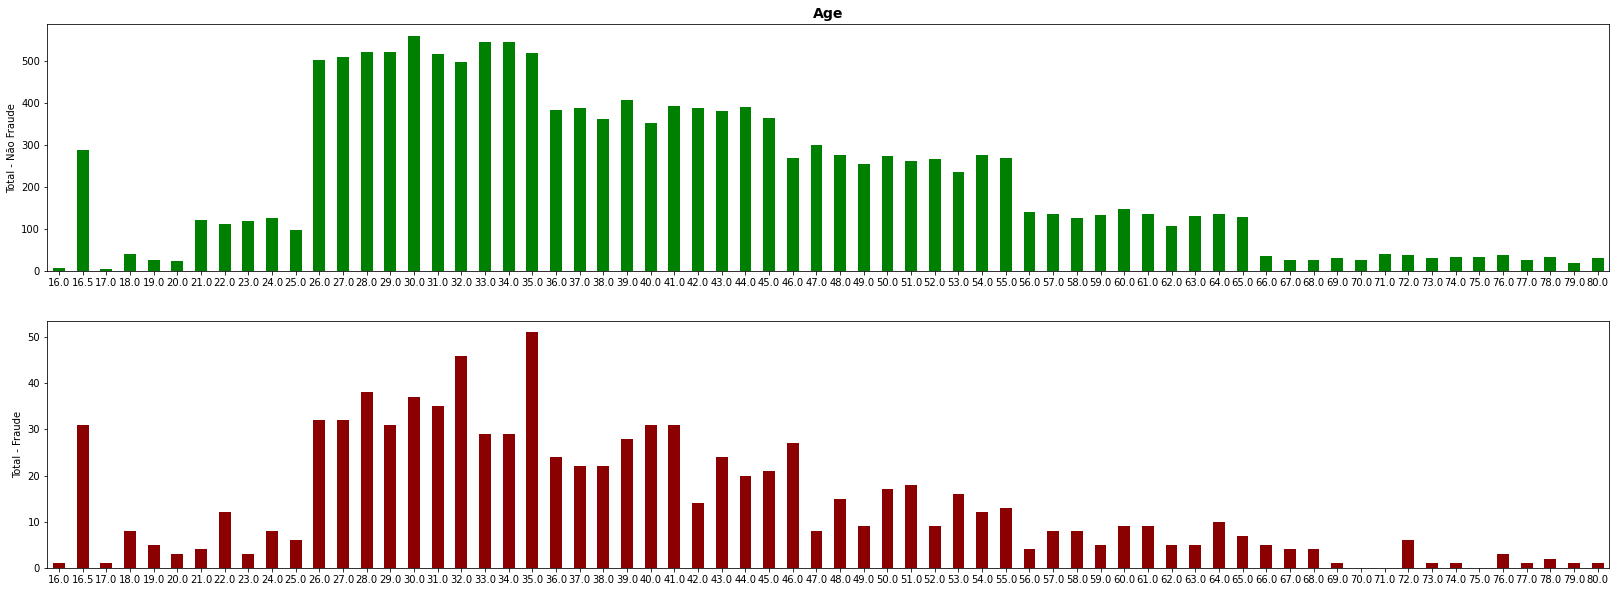

In [27]:
coluna = 'AgeOfPolicyHolder'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (8, 4))
plt.show()

coluna = 'Age'
tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (28, 10))
plt.show()

FraudFound_P     0    1
AgeOfVehicle           
2 years         70    3
3 years        139   13
4 years        208   21
5 years       1262   95
6 years       3220  228
7 years       5482  325
more than 7   3775  206
new            340   32


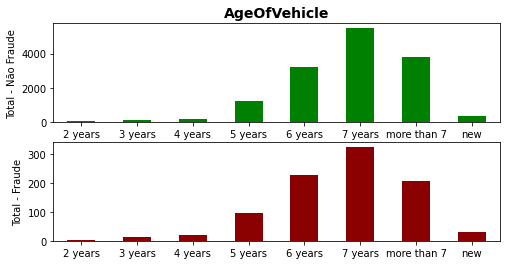

FraudFound_P      0    1
Sex                     
Female         2315  105
Male          12181  818


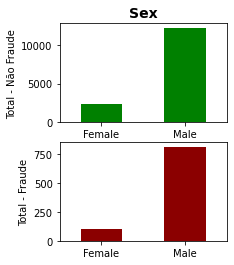

In [28]:
coluna = 'AgeOfVehicle'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (8, 4))
plt.show()

coluna = 'Sex'
tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (3, 4))
plt.show()

FraudFound_P      0    1
AgentType               
External      14259  919
Internal        237    4


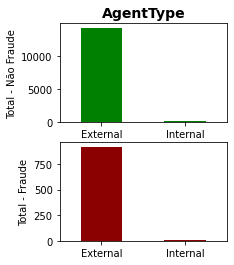

FraudFound_P     0    1
Year                   
1994          5732  409
1995          4894  301
1996          3870  213


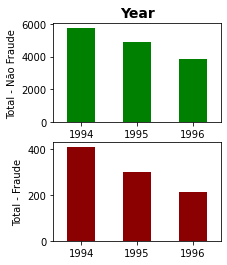

FraudFound_P              0    1
Days_Policy_Accident            
1 to 7                   13    1
15 to 30                 46    3
8 to 15                  50    5
more than 30          14341  905
none                     46    9


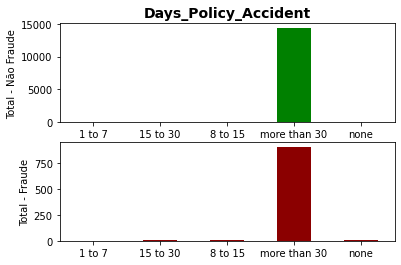

In [29]:
coluna = 'AgentType'

tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (3, 4))
plt.show()

coluna = 'Year'
tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (3, 4))
plt.show()

coluna = 'Days_Policy_Accident'
tab_cont = pd.crosstab(index=df_dataset_1[coluna], columns=df_dataset_1['FraudFound_P'])
print(tab_cont)
grafico_barras(tab_cont, coluna, (6, 4))
plt.show()

## PARTE 6: Transformar dados

In [30]:
df_dataset_2 = df_dataset_1.copy()

### 6.1. Conversão de dados categóricos e binários

A partir da investigação realizada anteriormente, os seguintes atributos categóricos podem ser transformados em binário:

**AccidentArea**: 1=Urban, 0=Rural

**Sex**: 1=Female, 0=Male

**Fault**: 1=Policy Holder, 0=Third Party

**PoliceReportFiled**: 1=No, 0=Yes

**WitnessPresent**: 1=No, 0=Yes

**AgentType**: 1=External 0=Internal

In [31]:
categorico_para_binario = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']

for coluna in categorico_para_binario:
    print(coluna)

    valores_unicos = df_dataset_2[coluna].unique()
    print(f"Valores antigos: {valores_unicos}")

    df_dataset_2[coluna] = df_dataset_2[coluna].replace(valores_unicos[0], 1).replace(valores_unicos[1], 0)

    valores_unicos = df_dataset_2[coluna].unique()
    print(f"Valores novos: {valores_unicos} \n")

AccidentArea
Valores antigos: ['Urban' 'Rural']
Valores novos: [1 0] 

Sex
Valores antigos: ['Female' 'Male']
Valores novos: [1 0] 

Fault
Valores antigos: ['Policy Holder' 'Third Party']
Valores novos: [1 0] 

PoliceReportFiled
Valores antigos: ['No' 'Yes']
Valores novos: [1 0] 

WitnessPresent
Valores antigos: ['No' 'Yes']
Valores novos: [1 0] 

AgentType
Valores antigos: ['External' 'Internal']
Valores novos: [1 0] 



In [32]:
df_dataset_2[categorico_para_binario].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   AccidentArea       15419 non-null  int64
 1   Sex                15419 non-null  int64
 2   Fault              15419 non-null  int64
 3   PoliceReportFiled  15419 non-null  int64
 4   WitnessPresent     15419 non-null  int64
 5   AgentType          15419 non-null  int64
dtypes: int64(6)
memory usage: 722.9 KB


### 6.2 Conversão dos dados ordinais

A partir da investigação realizada anteriormente, são atributos ordinais: 'Month', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed'. 

Estes devem corresponder à sua ordem natural. Exemplo: para o atributo 'Month', 'Jan' deve corresponder a 1, 'Feb' deve corresponder a 2, 'Mar' deve corresponder a 3, etc.

In [33]:
dias_da_semana = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
meses = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

Month = {'Month': meses}
DayOfWeek = {'DayOfWeek': dias_da_semana}
DayOfWeekClaimed = {'DayOfWeekClaimed': dias_da_semana}
MonthClaimed = {'MonthClaimed': meses}

mapping = [Month, DayOfWeek, DayOfWeekClaimed, MonthClaimed]

In [34]:
for i in range(len(mapping)):
    df_dataset_2.replace(mapping[i], inplace=True)

In [35]:
ordinais = ['Month', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed']

for coluna in ordinais:
    print(coluna)
    print(f"Valores antigos: {df_dataset_1[coluna].unique()}")
    print(f"Valores novos: {df_dataset_2[coluna].unique()} \n")

Month
Valores antigos: ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']
Valores novos: [12  1 10  6  2 11  4  3  8  7  5  9] 

DayOfWeek
Valores antigos: ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']
Valores novos: [3 5 6 1 2 7 4] 

DayOfWeekClaimed
Valores antigos: ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday']
Valores novos: [2 1 4 5 3 6 7] 

MonthClaimed
Valores antigos: ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct']
Valores novos: [ 1 11  7  2  3 12  4  8  5  6  9 10] 



### 6.3 Conversão dos dados de intervalo

A partir da investigação realizada anteriormente, são atributos de intervalos: 'PastNumberOfClaims', 'NumberOfSuppliments', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'AddressChange_Claim', 'NumberOfCars'. 

Estes serão nivelados por baixo. Exemplo: para o atributo 'NumberOfSuppliments', 'none' deve corresponder a 0, '1 to 2' deve corresponder a 1, '3 to 5' deve corresponder a 3 e 'more than 5' deve corresponder a 6.

In [36]:
PastNumberOfClaims = {'PastNumberOfClaims':{'none':0 ,'1':1,'2 to 4':2,'more than 4':5 }}
NumberOfSuppliments = {'NumberOfSuppliments':{'none':0,'1 to 2':1,'3 to 5':3,'more than 5':6}}
AgeOfVehicle = {'AgeOfVehicle':{'3 years':3,'6 years':6,'7 years':7,'more than 7':8,'5 years':5,'new':0,'4 years':4,'2 years':2}}
VehiclePrice = {'VehiclePrice':{'more than 69000':69001,'20000 to 29000':20000,'30000 to 39000':30000,'less than 20000':19999,
                                     '40000 to 59000':40000,'60000 to 69000':60000}}
Days_Policy_Accident = {'Days_Policy_Accident':{'more than 30':31,'15 to 30':15,'none':0,'1 to 7':1,'8 to 15':8}}
Days_Policy_Claim = {'Days_Policy_Claim':{'more than 30':31,'15 to 30':15,'8 to 15':8,'none':0}}
AgeOfPolicyHolder = {'AgeOfPolicyHolder':{'26 to 30':26,'31 to 35':31,'41 to 50':41,'51 to 65':51,'21 to 25':21,'36 to 40':36,
                                                            '16 to 17':16, 'over 65':66, '18 to 20':18}}
AddressChange_Claim = {'AddressChange_Claim':{'1 year':1,'no change':0,'4 to 8 years':4,'2 to 3 years':2,'under 6 months':0.5}}
NumberOfCars = {'NumberOfCars':{'3 to 4':3,'1 vehicle':1,'2 vehicles':2,'5 to 8':5,'more than 8':9}}

mapping = [PastNumberOfClaims, NumberOfSuppliments, VehiclePrice, AgeOfVehicle, Days_Policy_Accident, 
            Days_Policy_Claim, AgeOfPolicyHolder, AddressChange_Claim, NumberOfCars]

In [37]:
for i in range(len(mapping)):
    df_dataset_2.replace(mapping[i], inplace=True)

In [38]:
dados_intervalos = ['PastNumberOfClaims', 'NumberOfSuppliments', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 
                        'AgeOfVehicle', 'AgeOfPolicyHolder', 'AddressChange_Claim', 'NumberOfCars']

for coluna in dados_intervalos:
    print(coluna)
    print(f"Valores antigos: {df_dataset_1[coluna].unique()}")
    print(f"Valores novos: {df_dataset_2[coluna].unique()} \n")

PastNumberOfClaims
Valores antigos: ['none' '1' '2 to 4' 'more than 4']
Valores novos: [0 1 2 5] 

NumberOfSuppliments
Valores antigos: ['none' 'more than 5' '3 to 5' '1 to 2']
Valores novos: [0 6 3 1] 

VehiclePrice
Valores antigos: ['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']
Valores novos: [69001 20000 30000 19999 40000 60000] 

Days_Policy_Accident
Valores antigos: ['more than 30' '15 to 30' 'none' '1 to 7' '8 to 15']
Valores novos: [31 15  0  1  8] 

Days_Policy_Claim
Valores antigos: ['more than 30' '15 to 30' '8 to 15']
Valores novos: [31 15  8] 

AgeOfVehicle
Valores antigos: ['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']
Valores novos: [3 6 7 8 5 0 4 2] 

AgeOfPolicyHolder
Valores antigos: ['26 to 30' '31 to 35' '41 to 50' '51 to 65' '21 to 25' '36 to 40'
 '16 to 17' 'over 65' '18 to 20']
Valores novos: [26 31 41 51 21 36 16 66 18] 

AddressChange_Claim
Valores antigos: ['1 year' 

### 6.3 Conversão dos dados categóricos e nominais

A partir da investigação realizada anteriormente, os seguintes atributos são categóricos e nominais: 'Make','MaritalStatus','PolicyType','VehicleCategory' e 'BasePolicy'. Agora, estes terão uma representação vetorial binária.

In [39]:
df_dataset_2.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Columns: 32 entries, Month to BasePolicy
dtypes: float64(2), int64(25), object(5)
memory usage: 3.8+ MB


In [40]:
# get_dummies transforma as colunas do tipo 'object'

# 19 categorias de 'Make' + 4 categorias de 'MaritalStatus' + 9 categorias de 'PolicyType'
# + 3 categorias de 'VehicleCategory' + 3 categorias de 'BasePolicy'
# = 38 colunas
df_dataset_2 = pd.get_dummies(df_dataset_2);
df_dataset_2.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Columns: 65 entries, Month to BasePolicy_Liability
dtypes: float64(2), int64(25), uint8(38)
memory usage: 3.7 MB


## PARTE 7: Investigar relações com a variável alvo (novamente)

Será realizado o mesmo teste de independência executado na PARTE 5. A ideia é verificar se, após as transformações, aparecem novas relações relevantes entre os atributos e o target ('FraudFound_P').

In [41]:
df_final = df_dataset_2.copy()

In [42]:
# teste de independêndia chi-quadrado
nivel_significancia = 0.05
teste_independencia = []

for coluna in df_final.columns:
    tabela_contigencia = pd.crosstab(df_final[coluna], df_final['FraudFound_P'])
    chi2_val, valor_p, _, __ = stats.chi2_contingency(tabela_contigencia)
    if valor_p < nivel_significancia:
        teste_independencia.append([coluna, chi2_val, valor_p])

print("Há evidências estatísticas suficientes de que existe alguma relação entre FraudFound_P e os seguintes atributos:")

df_teste_independencia = pd.DataFrame(teste_independencia, columns=['Atributo', '\u03C7\u00B2', 'Valor-p'])
df_teste_independencia.sort_values(by='Valor-p', inplace=True)
print(df_teste_independencia)

Há evidências estatísticas suficientes de que existe alguma relação entre FraudFound_P e os seguintes atributos:
                           Atributo            χ²       Valor-p
7                      FraudFound_P  15401.236138  0.000000e+00
29             BasePolicy_Liability    364.390028  3.116620e-81
21     PolicyType_Sedan - Liability    361.581932  1.273869e-80
25            VehicleCategory_Sport    283.640594  1.208553e-63
5                             Fault    264.984556  1.406180e-59
24            VehicleCategory_Sedan    229.174903  9.021607e-52
27            BasePolicy_All Perils    192.648135  8.400805e-44
19    PolicyType_Sedan - All Perils    162.856618  2.688717e-37
15              AddressChange_Claim    104.722693  9.704718e-22
8                        Deductible     72.406255  1.302831e-15
6                      VehiclePrice     67.836116  2.888324e-13
10               PastNumberOfClaims     53.541755  1.405198e-11
22     PolicyType_Sport - Collision     37.152501  1.09

## PARTE 8: Dividir variáveis dependentes e independentes

Variável dependente/alvo: 'FraudFound_P'

In [43]:
X = df_final.drop('FraudFound_P', axis=1).copy()
y = df_final['FraudFound_P'].copy()
print(X.shape, y.shape)

(15419, 64) (15419,)


## PARTE 9: Dividir dados de treino e de teste

70% treino e 30% teste

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10793, 64) (4626, 64) (10793,) (4626,)


## PARTE 10: Balancear dados de treino

Método escolhido: ADASYN

In [45]:
y_train.value_counts()

0    10147
1      646
Name: FraudFound_P, dtype: int64

In [46]:
X_train_over, y_train_over = ADASYN().fit_resample(X_train, y_train)

In [47]:
y_train_over.value_counts()

0    10147
1    10088
Name: FraudFound_P, dtype: int64

## PARTE 11: Rodar experimentos

Serão avaliadas diferentes configurações do algoritmo Random Forest.

### 11.1 Criar o modelo de classificação e definir os possíveis hiperparâmetros

In [48]:
RF_classifier = RandomForestClassifier()
n_estimators = [10, 100, 300]
max_features = ['sqrt', 'log2']
max_depth = [3, 5, 8]
RF_grid = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)

### 11.2 Definir as métricas de comparação

In [49]:
metricas = {'accuracy_score':metrics.make_scorer(metrics.accuracy_score),
          'f1_score':metrics.make_scorer(metrics.f1_score),
          'roc_auc_score':metrics.make_scorer(metrics.roc_auc_score) 
         }

### 11.3 Definir os parâmetros dos experimentos

In [50]:
# validação cruzada
n_splits = 5
n_repeats = 5
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

### 11.4 Executar os experimentos

Os experimentos serão realizados a partir do 'GridSearchCV', assim, serão realizadas n repetições de validação cruzada para cada possível configuração de classificador. No final, teremos disponíveis, para cada métrica definida anteriormente, os resultados de cada experimento para cada configuração de classificador.

In [51]:
grid_search = GridSearchCV(estimator=RF_classifier, param_grid=RF_grid, cv=cv, scoring=metricas, refit='accuracy_score', error_score=0)
grid_result = grid_search.fit(X_train_over, y_train_over)

## PARTE 12: Analisar os resultados

É possível observar os resultados do grid search a partir do atributo 'cv_results_'. Para criar os gráficos, será realizado um tratamento no formato original retornado por esse atributo.

In [52]:
id_vars = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'mean_test_accuracy_score', 'std_test_accuracy_score', 'rank_test_accuracy_score', 'mean_test_f1_score', 'std_test_f1_score', 'rank_test_f1_score', 'mean_test_roc_auc_score', 'std_test_roc_auc_score', 'rank_test_roc_auc_score']
id_vars = id_vars + ['param_max_features', 'param_n_estimators', 'param_max_depth']

df_results_RF = pd.DataFrame(grid_result.cv_results_)

df_results_RF = pd.melt(df_results_RF, id_vars=id_vars)

In [53]:
df_results_RF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mean_fit_time             1350 non-null   float64
 1   std_fit_time              1350 non-null   float64
 2   mean_score_time           1350 non-null   float64
 3   std_score_time            1350 non-null   float64
 4   params                    1350 non-null   object 
 5   mean_test_accuracy_score  1350 non-null   float64
 6   std_test_accuracy_score   1350 non-null   float64
 7   rank_test_accuracy_score  1350 non-null   int32  
 8   mean_test_f1_score        1350 non-null   float64
 9   std_test_f1_score         1350 non-null   float64
 10  rank_test_f1_score        1350 non-null   int32  
 11  mean_test_roc_auc_score   1350 non-null   float64
 12  std_test_roc_auc_score    1350 non-null   float64
 13  rank_test_roc_auc_score   1350 non-null   int32  
 14  param_ma

In [54]:
df_results_RF[['params', 'variable', 'value']]

,params,variable,value
0,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",split0_test_accuracy_score,0.791698
1,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",split0_test_accuracy_score,0.832963
2,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",split0_test_accuracy_score,0.835434
3,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",split0_test_accuracy_score,0.846306
4,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",split0_test_accuracy_score,0.843094
...,...,...,...
1345,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...",split24_test_roc_auc_score,0.915609
1346,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...",split24_test_roc_auc_score,0.917331
1347,"{'max_depth': 8, 'max_features': 'log2', 'n_es...",split24_test_roc_auc_score,0.907197
1348,"{'max_depth': 8, 'max_features': 'log2', 'n_es...",split24_test_roc_auc_score,0.919056


Agora, basta filtrar cada configuração dos parâmetros e cada métrica para que tenhamos os resultados de cada experimento realizado.

In [55]:
def valores(modelo, parametros, metrica):
  col1, param1, col2, param2, col3, param3 = parametros
  val = modelo[(modelo["param_"+col1]==param1) & (modelo["param_"+col2]==param2) & (modelo["param_"+col3]==param3)]
  val = val.loc[val.variable.str.contains(f'[a-zA-Z]+[0-9]+_[a-zA-Z]+_{metrica}+'), 'value']
  return val

In [56]:
metrica = [*metricas.keys()]
dict_acuracia, dict_f1, dict_roc = {}, {}, {}

parametros_combinacoes = list( df_results_RF['params'].value_counts().index )

for combinacao in [i.items() for i in parametros_combinacoes]:
    # param = (nome, valor)
    param1, param2, param3 = list(combinacao)
    parametros = [param1[0], param1[1], param2[0], param2[1], param3[0], param3[1]]
    nome_coluna = f"{param1[0][:6]}_{param1[1]}-{param2[0][:6]}_{param2[1]}-{param3[0][:6]}_{param3[1]}"

    dict_acuracia[nome_coluna] = valores(df_results_RF, parametros, metrica[0])
    dict_f1[nome_coluna] = valores(df_results_RF, parametros, metrica[1])
    dict_roc[nome_coluna] = valores(df_results_RF, parametros, metrica[2])

df_acuracia, df_f1, df_roc = pd.DataFrame(dict_acuracia), pd.DataFrame(dict_f1), pd.DataFrame(dict_roc)

In [57]:
# exemplo de como estão sendo armazenados os resultados
df_acuracia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   max_de_8-max_fe_log2-n_esti_10   25 non-null     float64
 1   max_de_5-max_fe_log2-n_esti_300  25 non-null     float64
 2   max_de_3-max_fe_log2-n_esti_100  25 non-null     float64
 3   max_de_5-max_fe_sqrt-n_esti_300  25 non-null     float64
 4   max_de_8-max_fe_sqrt-n_esti_10   25 non-null     float64
 5   max_de_8-max_fe_log2-n_esti_100  25 non-null     float64
 6   max_de_3-max_fe_sqrt-n_esti_100  25 non-null     float64
 7   max_de_3-max_fe_log2-n_esti_300  25 non-null     float64
 8   max_de_5-max_fe_log2-n_esti_10   25 non-null     float64
 9   max_de_8-max_fe_sqrt-n_esti_100  25 non-null     float64
 10  max_de_8-max_fe_log2-n_esti_300  25 non-null     float64
 11  max_de_3-max_fe_sqrt-n_esti_300  25 non-null     float64
 12  max_de_5-max_fe_sqrt-n

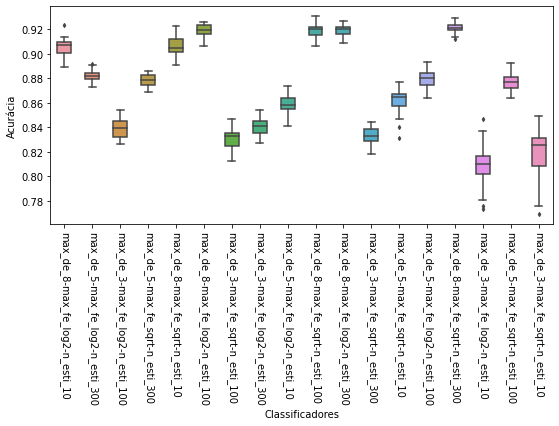

In [58]:
#plot acurácia
fig, ax = plt.subplots(figsize=(9,4))
sns.boxplot(ax=ax, data=df_acuracia, width=0.5, fliersize=3)
ax.set_xlabel("Classificadores")
ax.set_ylabel("Acurácia")
plt.xticks(rotation=-90)
plt.show()

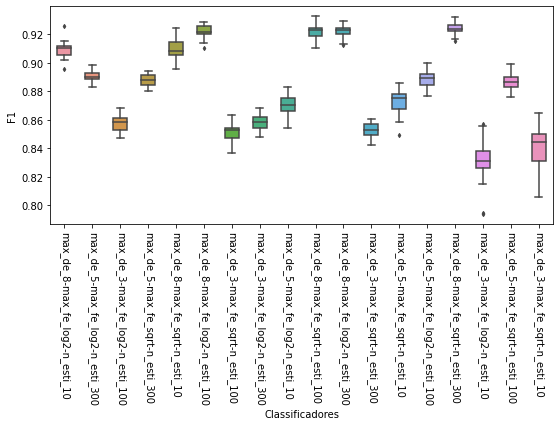

In [59]:
#plot f1 score
fig, ax = plt.subplots(figsize=(9,4))
sns.boxplot(ax=ax, data=df_f1, width=0.5, fliersize=3)
ax.set_xlabel("Classificadores")
ax.set_ylabel("F1")
plt.xticks(rotation=-90)
plt.show()

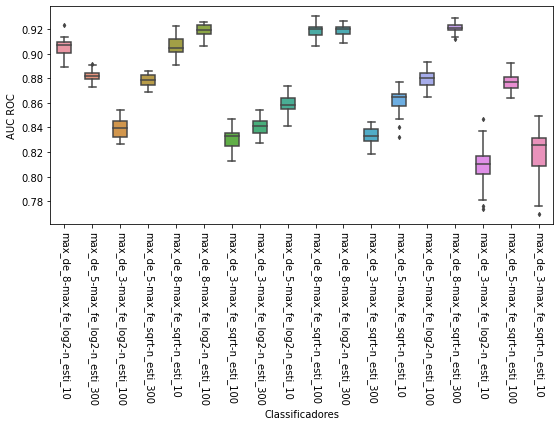

In [60]:
#plot área sob a curva ROC
fig, ax = plt.subplots(figsize=(9,4))
sns.boxplot(ax=ax, data=df_roc, width=0.5, fliersize=3)
ax.set_xlabel("Classificadores")
ax.set_ylabel("AUC ROC")
plt.xticks(rotation=-90)
plt.show()

Observando cada configuração, os valores para cada uma das três métricas são semelhantes. É importante deixar claro que não há um significado específico para isso. Conhecendo as expressões matemáticas de cada uma dessas métricas, esse comportamento é previsto quando os valores de Falso Positivo e Falso Negativo são iguais (ou perto disso) e pequenos.

Com isso, a configuração escolhida é a com melhor desempenho (considerando a distribuição próximo a 1) em todas (ou na maioria) das métricas. Sendo assim, foi escolhida a configuração com max_depth=8, n_estimators=300 e max_features='sqrt'.

## PARTE 13: Investigar o melhor modelo

In [62]:
best_model = RandomForestClassifier(max_depth=8, n_estimators=300, max_features='sqrt').fit(X_train_over, y_train_over)

A primeira abordagem escolhida como forma de entender quais atributos são considerados mais relevantes na classificação do modelo com melhor desempenho foi a de observar a Importância da Permutação. Este método embaralha aleatoriamente cada atributo e calcula a mudança no desempenho do modelo. Então, quanto mais uma mudança em um determinado atributo impacta no desempenho do modelo, mais importante este atributo é.

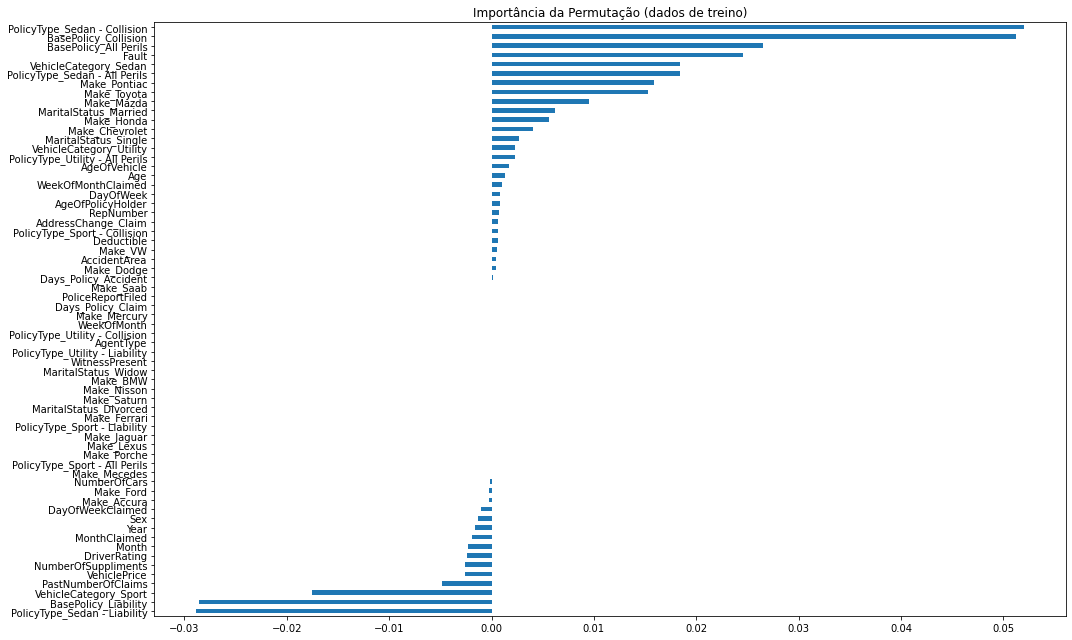

In [63]:
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10)

best_model_importances = pd.Series(perm_importance.importances_mean, index=X_test.columns)
best_model_importances = best_model_importances.sort_values(ascending=True)

fig, ax = plt.subplots()
best_model_importances.plot.barh(yerr=perm_importance.importances_std, ax=ax, figsize=(15,9))
ax.set_title("Importância da Permutação (dados de treino)")
fig.tight_layout()
plt.show()

Porém, um problema foi notado: comparando o resultado acima com o teste de independência realizado na PARTE 7, é possível observar que os dois atributos que aparentam ter maior relação com a variável alvo ('BasePolicy_Liability' e 'PolicyType_Sedan - Liability'), aparecem com uma importância baixíssima.

Isso se dá por conta de uma limitação da abordagem escolhida. A Importância da Permutação não performa bem caso existam atributos que não sejam totalmente independentes e que, de alguma forma, se correlacionem. E, como pode ser visto abaixo, estes dois atributos citados podem ser considerados colineares (se correlacionando de alguma forma, mas não necessariamente com uma relação estritamente linear).

In [64]:
pd.crosstab(df_final['PolicyType_Sedan - Liability'], df_final['BasePolicy_Liability'])

BasePolicy_Liability,0,1
PolicyType_Sedan - Liability,,
0,10410,22
1,0,4987


Uma outra forma de entender quais atributos são considerados mais relevantes na classificação do modelo com melhor desempenho é com a Importância da Característica da Floresta Aleatória, um recurso baseado em impureza. O princípio desse método é baseado no critério considerado na divisão dos nós em uma árvore de decisão, onde a 'impureza' se refere a uma métrica usada para determinar como (usando qual atributo e em qual limite) dividir os dados em grupos menores. 

Se o atributo é útil, este tende a dividir nós rotulados mistos em nós puros de classe única. Então, podemos medir como cada atributo diminui a impureza da divisão (o recurso com maior diminuição é selecionado para o nó interno). Para cada atributo, podemos coletar como, em média, diminui a impureza. A média de todas as árvores é a medida da importância da característica.

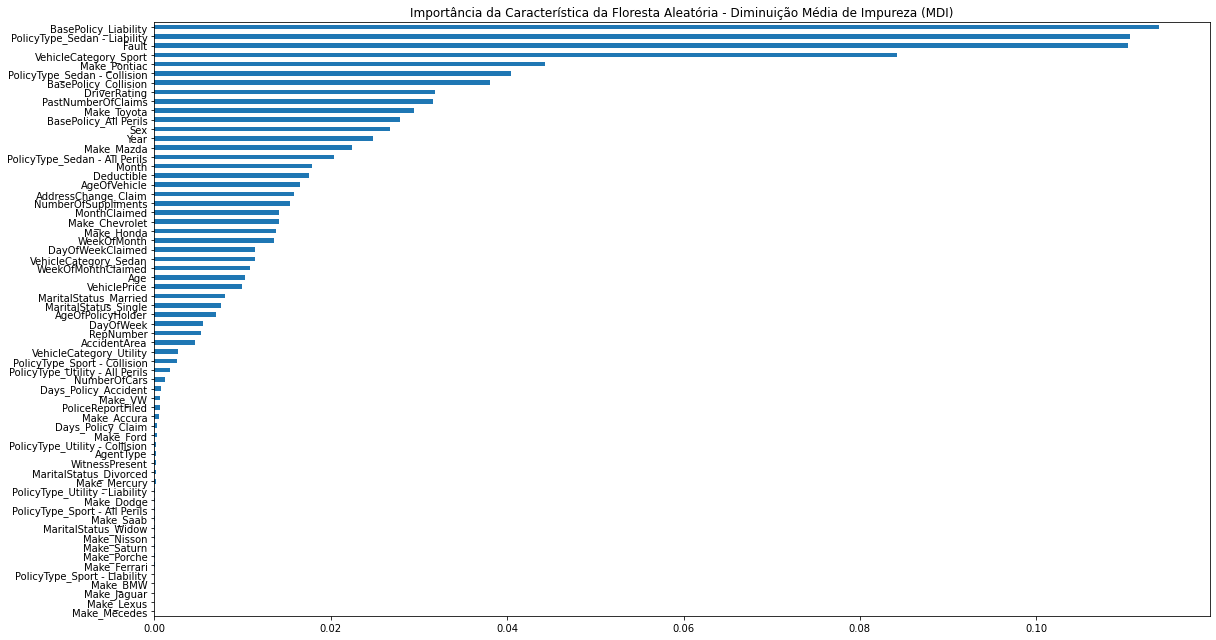

In [65]:
importances = best_model.feature_importances_
best_model_importances = pd.Series(importances, index=X_train_over.columns)
best_model_importances = best_model_importances.sort_values(ascending=True)

fig, ax = plt.subplots()
best_model_importances.plot.barh(ax=ax, figsize=(17,9))
ax.set_title("Importância da Característica da Floresta Aleatória - Diminuição Média de Impureza (MDI)")
fig.tight_layout()

Como todos os valores necessários são calculados durante o treinamento, este método é executado rapidamente. Além disso, é possível observar um comportamento mais semelhante com o resultado obtido no teste de independência da PARTE 7. Porém, é importante salientar que este método tem a tendência de preferir (selecionar como importantes) atributos numéricos e atributos categóricos com alta cardinalidade (muitos valores exclusivos, como era o caso de 'PolicyNumber', excluído no tratamento dos dados). E, no caso de atributos correlacionados, pode-se selecionar apenas um dos atributos e negligenciar a importância do outro (o que pode levar a conclusões erradas).

É importante entender que qualquer abordagem escolhida traz consigo alguma limitação. Para este projeto, apesar das desvantagens comentadas, o segundo método apresentou o melhor desempenho, corroborando com algumas análises realizadas anteriormente e permitindo uma maior compreensão do problema.

Agora, com o modelo treinado (usando dados balanceados), verificaremos a performance com os dados de teste (que mantêm a proporção original).

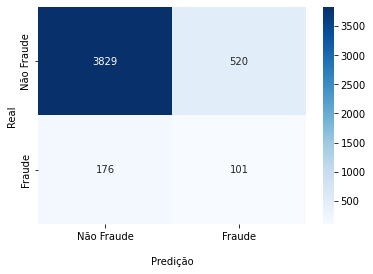

In [66]:
y_pred = best_model.predict(X_test)

matriz_confusao = metrics.confusion_matrix(y_test, y_pred)

ax = sns.heatmap(matriz_confusao, annot=True, fmt='g', cmap='Blues')

ax.set(xlabel='\nPredição', ylabel='Real')
ax.set(xticklabels=['Não Fraude', 'Fraude'], yticklabels=['Não Fraude', 'Fraude'])

plt.show()

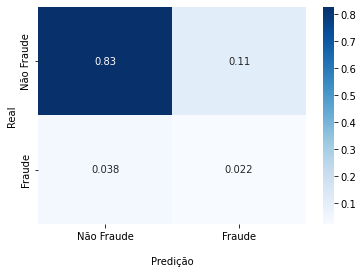

In [67]:
ax1 = sns.heatmap(matriz_confusao/np.sum(matriz_confusao), annot=True, cmap='Blues')

ax1.set(xlabel='\nPredição', ylabel='Real')
ax1.set(xticklabels=['Não Fraude', 'Fraude'], yticklabels=['Não Fraude', 'Fraude'])

plt.show()

In [68]:
print(f"acurácia: {metrics.accuracy_score(y_test, y_pred)}")
print(f"precisão: {metrics.precision_score(y_test, y_pred)}")
print(f"recall: {metrics.recall_score(y_test, y_pred)}")
print(f"f1-score: {metrics.f1_score(y_test, y_pred)}")
print(f"AUC ROC: {metrics.roc_auc_score(y_test, y_pred)}")

acurácia: 0.8495460440985733
precisão: 0.16264090177133655
recall: 0.36462093862815886
f1-score: 0.22494432071269488
AUC ROC: 0.6225266109558362


## PARTE 14: Conclusão e discussão

Nota-se um desempenho diferente, em geral menor, quando observados os resultados de teste, comparando-os com os resultados da validação cruzada. Porém, isso é esperado, pois os dados utilizados na validação cruzada e no teste são diferentes e, ainda mais importante, os dados de teste apresentam o desbalanceamento real de solicitações identificadas ou não como fraudulentas. Dessa forma, conseguimos verificar se, de fato, o modelo aprendeu a generalizar o problema.

O que é possível tirar de conclusão a partir dos resultados:

- a pessoa considerada culpada pelo acidente (titular da apólice ou terceiro) demonstra ser bastante importante;

- o tipo de apólice contratada se mostra bem relevante para algumas das suas possíveis combinações, como para o tipo de seguro 'Liability' (indenização à terceiros quando o titular da apólice é o culpado) e para as categorias de veículo 'Sedan' e 'Sport';

- em relação ao histórico do titular da apólice vemos 'AddressChange_Claim' e 'PastNumberOfClaims' como fatores importantes. Porém, 'Days_Policy_Accident' e 'Days_Policy_Claim' não parecem ser tão significativos;

- já sobre as características pessoais  do titular da apólice/condutor, observa-se uma relevância maior para 'Sex' e um pouco menos para 'Age' e 'MaritalStatus';

- alguns fatores mostraram pouca relevância para o problema, como: presença de testemunha no momento do acidente ('WitnessPresent'), realização de boletim de ocorrência para o acontecido ('PoliceReportFiled') e a área em que o acidente ocorreu ('AccidentArea').